In [27]:
# 1. Import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
import yfinance as yf

In [4]:
# 2. Import dataset and set index
data = yf.download(tickers = "GRAB", start="2020-12-01", end="2023-12-26", interval='1d')
data = data.reset_index('Date', inplace=False)
data = data.reset_index()['Close']
data

[*********************100%%**********************]  1 of 1 completed


0      11.89
1      11.82
2      11.90
3      12.40
4      12.55
       ...  
766     3.16
767     3.25
768     3.17
769     3.26
770     3.22
Name: Close, Length: 771, dtype: float64

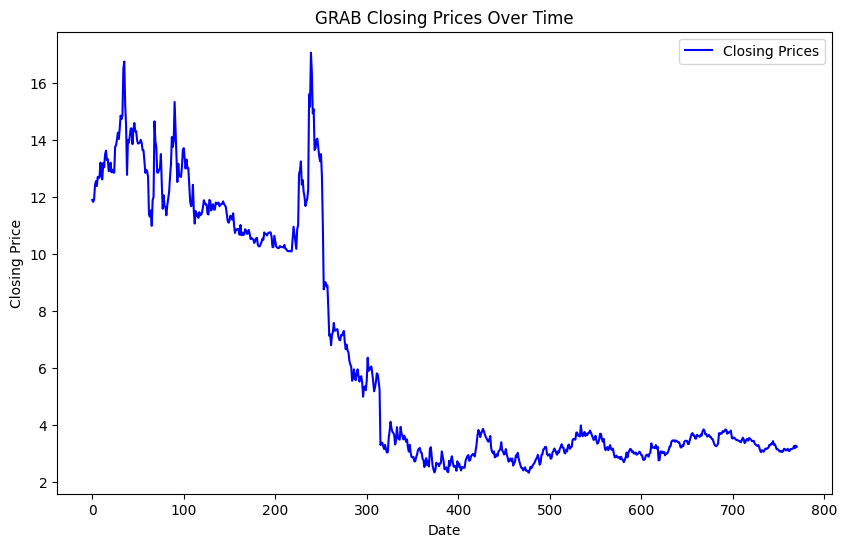

In [5]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(data, label='Closing Prices', color='blue')
plt.title('GRAB Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

# 6-3-1

In [33]:
df= data

In [34]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df=scaler.fit_transform(np.array(df).reshape(-1,1))

In [35]:
# 4. Split train test
train_size = int(0.6 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [36]:
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))

In [37]:
# 5. create_dataset function
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [38]:
#6. Reshape into X=t,t+1,t+2..t+29 and Y=t+30

time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [39]:
# 7. Reshape input to be [samples, time steps, features] which is required for RNN

X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [40]:
# 8. Define RNN Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [41]:
# 9. Fit the modle with train data
# 9. Fit the modle with train data
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
7/7 [==============================] - 1s 53ms/step - loss: 0.0129 - val_loss: 8.3748e-04
Epoch 2/100
7/7 [==============================] - 0s 15ms/step - loss: 0.0057 - val_loss: 7.0630e-04
Epoch 3/100
7/7 [==============================] - 0s 16ms/step - loss: 0.0041 - val_loss: 2.2490e-04
Epoch 4/100
7/7 [==============================] - 0s 15ms/step - loss: 0.0032 - val_loss: 5.4806e-04
Epoch 5/100
7/7 [==============================] - 0s 15ms/step - loss: 0.0027 - val_loss: 2.1410e-04
Epoch 6/100
7/7 [==============================] - 0s 15ms/step - loss: 0.0023 - val_loss: 2.0895e-04
Epoch 7/100
7/7 [==============================] - 0s 16ms/step - loss: 0.0022 - val_loss: 1.4103e-04
Epoch 8/100
7/7 [==============================] - 0s 16ms/step - loss: 0.0021 - val_loss: 1.4034e-04
Epoch 9/100
7/7 [==============================] - 0s 16ms/step - loss: 0.0020 - val_loss: 1.2775e-04
Epoch 10/100
7/7 [==============================] - 0s 15ms/step - loss: 0.0018 - 

In [42]:
# 10. Predict test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

2/2 [==============================] - 0s 7ms/step


In [43]:
# 11. Inverse scaled data y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [44]:
# Chia train test lại
ytest = scaler.inverse_transform(ytest.reshape(-1,1))

yval = scaler.inverse_transform(yval.reshape(-1,1))

In [45]:
# 12. Đánh giá độ chính xác thuật toán
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 0.06553968769789041
Testing RMSE: 0.11846545905606132


In [46]:
from sklearn.metrics import mean_absolute_error
valid_mae = mean_absolute_error(yval, y_pred_val)
test_mae = mean_absolute_error(ytest, y_pred)
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation MAE: 0.05490189917544101
Testing MAE: 0.08987830519676208


In [47]:
from sklearn.metrics import mean_absolute_percentage_error
valid_mape = mean_absolute_percentage_error(yval, y_pred_val)
test_mape = mean_absolute_percentage_error(ytest, y_pred)
print('Validation MAPE:', valid_rmse)
print('Testing MAPE:', test_rmse)

Validation MAPE: 0.06553968769789041
Testing MAPE: 0.11846545905606132


In [48]:
# 13. Dự báo 30 ngày tiếp theo
n_steps=30
start_index = max(0, len(val_data) - n_steps)

# Take the last 30 elements
selected_data = val_data[start_index:]
# Reshape for x_input
x_input = selected_data.reshape(1, -1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=30
i=0
while(i<30):

    if(len(temp_input)>30):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.06269831]
31
1 day input [0.06915254 0.06847458 0.07525425 0.06644068 0.06779661 0.06237289
 0.05559323 0.05559323 0.05491525 0.05084746 0.05016949 0.05220339
 0.04949153 0.05152542 0.05694916 0.0562712  0.05288136 0.05423729
 0.05694916 0.05220339 0.05152542 0.0562712  0.0562712  0.05694916
 0.05762713 0.06372882 0.0583051  0.06440678 0.06169492 0.06269831]
1 day output [[0.06317323]]
2 day input [0.06847458 0.07525425 0.06644068 0.06779661 0.06237289 0.05559323
 0.05559323 0.05491525 0.05084746 0.05016949 0.05220339 0.04949153
 0.05152542 0.05694916 0.0562712  0.05288136 0.05423729 0.05694916
 0.05220339 0.05152542 0.0562712  0.0562712  0.05694916 0.05762713
 0.06372882 0.0583051  0.06440678 0.06169492 0.06269831 0.06317323]
2 day output [[0.0612565]]
3 day input [0.07525425 0.06644068 0.06779661 0.06237289 0.05559323 0.05559323
 0.05491525 0.05084746 0.05016949 0.05220339 0.04949153 0.05152542
 0.05694916 0.0562712  0.05288136 0.05423729 0.05694916 0.05220339
 0.05152542 0.056271

[*********************100%%**********************]  1 of 1 completed


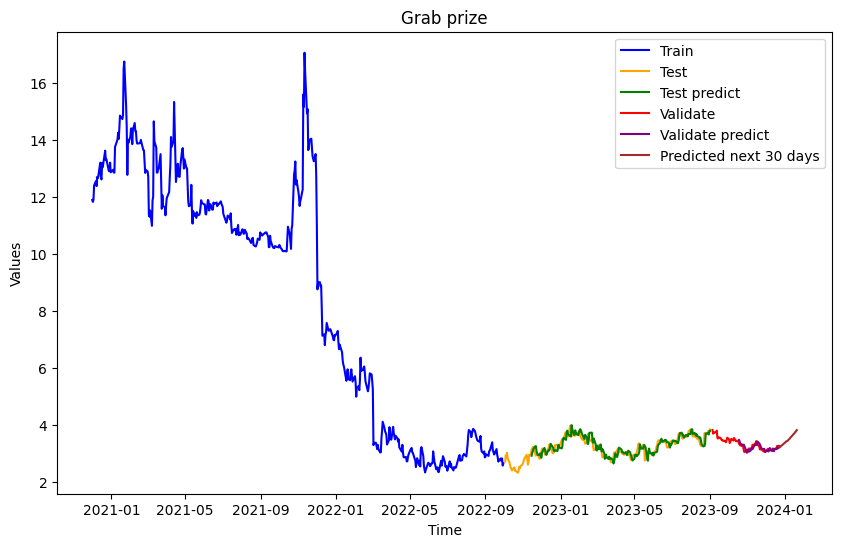

In [49]:
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

date = yf.download(tickers = "GRAB", start="2020-12-01", end="2023-12-26", interval='1d')
date = date.reset_index()

plt.figure(figsize=(10, 6)) 

train_plot = scaler.inverse_transform(train_data)
test_plot = scaler.inverse_transform(test_data)
test_pred_plot = y_pred
val_plot = scaler.inverse_transform(val_data)
val_pred_plot = y_pred_val
predicted_data = np.array(scaler.inverse_transform(lst_output).flatten())
# Plot real data
plt.plot(date['Date'][:len(train_plot)],train_plot, label='Train', color='blue')

# Plot predicted data starting from the end of real data
start_index = len(train_data)
end_index = start_index + len(test_data)
plt.plot(date['Date'][start_index:end_index], test_plot, label='Test', color='orange')
plt.plot(date['Date'][end_index-len(y_pred):end_index], test_pred_plot, label='Test predict', color='green')
# Plot predicted data starting from the end of real data
start_index = end_index
end_index = start_index + len(val_data)
plt.plot(date['Date'][start_index:end_index], val_plot, label='Validate', color='red')
plt.plot(date['Date'][end_index-len(y_pred_val):end_index], y_pred_val, label='Validate predict', color='purple')
# Plot predicted data starting from the end of real data
start_index = end_index
end_index = start_index + len(predicted_data)
plt.plot(pd.date_range(start=date['Date'].iloc[-1], end="2024-01-20", freq='D'), predicted_data, label='Predicted next 30 days', color='brown')


# Set labels and title
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Grab prize')
plt.legend()

plt.show()

# 7-2-1

In [50]:
df= data

In [67]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df=scaler.fit_transform(np.array(df).reshape(-1,1))

In [68]:
# 4. Split train test
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [69]:
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))

In [70]:
# 5. create_dataset function
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [71]:
#6. Reshape into X=t,t+1,t+2..t+29 and Y=t+30

time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [72]:
# 7. Reshape input to be [samples, time steps, features] which is required for RNN

X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [73]:
# 8. Define RNN Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [74]:
# 9. Fit the modle with train data
# 9. Fit the modle with train data
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
8/8 [==============================] - 1s 47ms/step - loss: 0.0528 - val_loss: 0.0125
Epoch 2/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0095 - val_loss: 0.0022
Epoch 3/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0060 - val_loss: 0.0011
Epoch 4/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0047 - val_loss: 0.0012
Epoch 5/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0037 - val_loss: 4.0531e-04
Epoch 6/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0036 - val_loss: 4.6576e-04
Epoch 7/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0033 - val_loss: 2.5345e-04
Epoch 8/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0031 - val_loss: 2.4009e-04
Epoch 9/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0030 - val_loss: 2.5430e-04
Epoch 10/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0028 - val_loss: 2.2626

In [75]:
# 10. Predict test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

2/2 [==============================] - 0s 5ms/step


In [76]:
# 11. Inverse scaled data y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [77]:
# Chia train test lại
ytest = scaler.inverse_transform(ytest.reshape(-1,1))

yval = scaler.inverse_transform(yval.reshape(-1,1))

In [78]:
# 12. Đánh giá độ chính xác thuật toán
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 0.0041103794578008996
Testing RMSE: 0.007397376573051557


In [79]:
from sklearn.metrics import mean_absolute_error
valid_mae = mean_absolute_error(yval, y_pred_val)
test_mae = mean_absolute_error(ytest, y_pred)
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation MAE: 0.003285423985958889
Testing MAE: 0.005531367627286699


In [80]:
from sklearn.metrics import mean_absolute_percentage_error
valid_mape = mean_absolute_percentage_error(yval, y_pred_val)
test_mape = mean_absolute_percentage_error(ytest, y_pred)
print('Validation MAPE:', valid_rmse)
print('Testing MAPE:', test_rmse)

Validation MAPE: 0.0041103794578008996
Testing MAPE: 0.007397376573051557


In [81]:
# 13. Dự báo 30 ngày tiếp theo
n_steps=30
start_index = max(0, len(val_data) - n_steps)

# Take the last 30 elements
selected_data = val_data[start_index:]
# Reshape for x_input
x_input = selected_data.reshape(1, -1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=30
i=0
while(i<30):

    if(len(temp_input)>30):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.05894844]
31
1 day input [0.06915254 0.06847458 0.07525425 0.06644068 0.06779661 0.06237289
 0.05559323 0.05559323 0.05491525 0.05084746 0.05016949 0.05220339
 0.04949153 0.05152542 0.05694916 0.0562712  0.05288136 0.05423729
 0.05694916 0.05220339 0.05152542 0.0562712  0.0562712  0.05694916
 0.05762713 0.06372882 0.0583051  0.06440678 0.06169492 0.05894844]
1 day output [[0.06073226]]
2 day input [0.06847458 0.07525425 0.06644068 0.06779661 0.06237289 0.05559323
 0.05559323 0.05491525 0.05084746 0.05016949 0.05220339 0.04949153
 0.05152542 0.05694916 0.0562712  0.05288136 0.05423729 0.05694916
 0.05220339 0.05152542 0.0562712  0.0562712  0.05694916 0.05762713
 0.06372882 0.0583051  0.06440678 0.06169492 0.05894844 0.06073226]
2 day output [[0.05862865]]
3 day input [0.07525425 0.06644068 0.06779661 0.06237289 0.05559323 0.05559323
 0.05491525 0.05084746 0.05016949 0.05220339 0.04949153 0.05152542
 0.05694916 0.0562712  0.05288136 0.05423729 0.05694916 0.05220339
 0.05152542 0.05627

[*********************100%%**********************]  1 of 1 completed


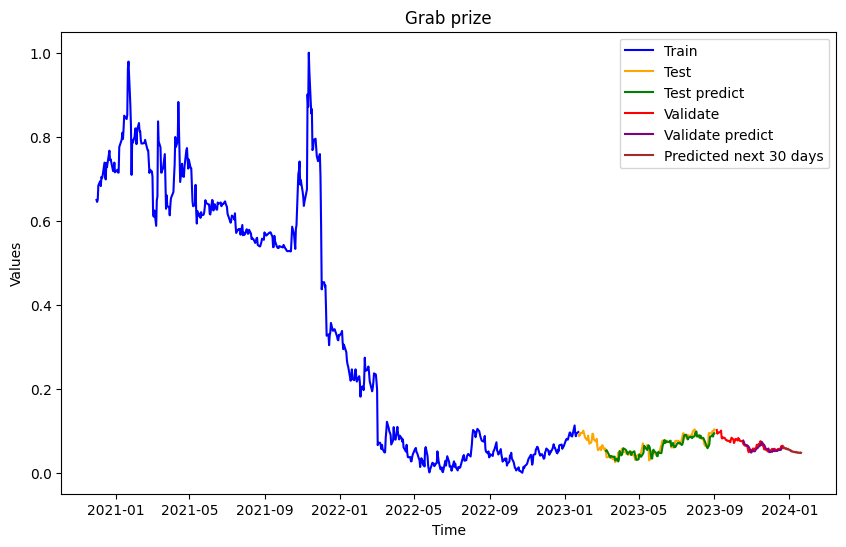

In [82]:
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

date = yf.download(tickers = "GRAB", start="2020-12-01", end="2023-12-26", interval='1d')
date = date.reset_index()

plt.figure(figsize=(10, 6)) 

train_plot = scaler.inverse_transform(train_data)
test_plot = scaler.inverse_transform(test_data)
test_pred_plot = y_pred
val_plot = scaler.inverse_transform(val_data)
val_pred_plot = y_pred_val
predicted_data = np.array(scaler.inverse_transform(lst_output).flatten())
# Plot real data
plt.plot(date['Date'][:len(train_plot)],train_plot, label='Train', color='blue')

# Plot predicted data starting from the end of real data
start_index = len(train_data)
end_index = start_index + len(test_data)
plt.plot(date['Date'][start_index:end_index], test_plot, label='Test', color='orange')
plt.plot(date['Date'][end_index-len(y_pred):end_index], test_pred_plot, label='Test predict', color='green')
# Plot predicted data starting from the end of real data
start_index = end_index
end_index = start_index + len(val_data)
plt.plot(date['Date'][start_index:end_index], val_plot, label='Validate', color='red')
plt.plot(date['Date'][end_index-len(y_pred_val):end_index], y_pred_val, label='Validate predict', color='purple')
# Plot predicted data starting from the end of real data
start_index = end_index
end_index = start_index + len(predicted_data)
plt.plot(pd.date_range(start=date['Date'].iloc[-1], end="2024-01-20", freq='D'), predicted_data, label='Predicted next 30 days', color='brown')


# Set labels and title
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Grab prize')
plt.legend()

plt.show()

# 8-1-1

In [50]:
df= data

In [51]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df=scaler.fit_transform(np.array(df).reshape(-1,1))

In [52]:
# 4. Split train test
train_size = int(0.8 * len(df))
test_size = int(0.1 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [53]:
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))

In [54]:
# 5. create_dataset function
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [55]:
#6. Reshape into X=t,t+1,t+2..t+29 and Y=t+30

time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [56]:
# 7. Reshape input to be [samples, time steps, features] which is required for RNN

X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [57]:
# 8. Define RNN Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [58]:
# 9. Fit the modle with train data
# 9. Fit the modle with train data
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
10/10 [==============================] - 2s 37ms/step - loss: 0.0533 - val_loss: 8.6300e-04
Epoch 2/100
10/10 [==============================] - 0s 12ms/step - loss: 0.0083 - val_loss: 0.0015
Epoch 3/100
10/10 [==============================] - 0s 12ms/step - loss: 0.0062 - val_loss: 0.0021
Epoch 4/100
10/10 [==============================] - 0s 12ms/step - loss: 0.0049 - val_loss: 3.4632e-04
Epoch 5/100
10/10 [==============================] - 0s 11ms/step - loss: 0.0043 - val_loss: 3.8559e-04
Epoch 6/100
10/10 [==============================] - 0s 12ms/step - loss: 0.0036 - val_loss: 2.4281e-04
Epoch 7/100
10/10 [==============================] - 0s 11ms/step - loss: 0.0034 - val_loss: 5.8001e-04
Epoch 8/100
10/10 [==============================] - 0s 11ms/step - loss: 0.0038 - val_loss: 2.0077e-04
Epoch 9/100
10/10 [==============================] - 0s 12ms/step - loss: 0.0031 - val_loss: 1.9913e-04
Epoch 10/100
10/10 [==============================] - 0s 12ms/step - los

In [59]:
# 10. Predict test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

2/2 [==============================] - 0s 5ms/step


In [60]:
# 11. Inverse scaled data y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [61]:
# Chia train test lại
ytest = scaler.inverse_transform(ytest.reshape(-1,1))

yval = scaler.inverse_transform(yval.reshape(-1,1))

In [62]:
# 12. Đánh giá độ chính xác thuật toán
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 0.10467466638744292
Testing RMSE: 0.15588966071070154


In [63]:
from sklearn.metrics import mean_absolute_error
valid_mae = mean_absolute_error(yval, y_pred_val)
test_mae = mean_absolute_error(ytest, y_pred)
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation MAE: 0.09069282450574509
Testing MAE: 0.12468994182089096


In [64]:
from sklearn.metrics import mean_absolute_percentage_error
valid_mape = mean_absolute_percentage_error(yval, y_pred_val)
test_mape = mean_absolute_percentage_error(ytest, y_pred)
print('Validation MAPE:', valid_rmse)
print('Testing MAPE:', test_rmse)

Validation MAPE: 0.10467466638744292
Testing MAPE: 0.15588966071070154


In [65]:
# 13. Dự báo 30 ngày tiếp theo
n_steps=30
start_index = max(0, len(val_data) - n_steps)

# Take the last 30 elements
selected_data = val_data[start_index:]
# Reshape for x_input
x_input = selected_data.reshape(1, -1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=30
i=0
while(i<30):

    if(len(temp_input)>30):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.05599218]
31
1 day input [0.06915254 0.06847458 0.07525425 0.06644068 0.06779661 0.06237289
 0.05559323 0.05559323 0.05491525 0.05084746 0.05016949 0.05220339
 0.04949153 0.05152542 0.05694916 0.0562712  0.05288136 0.05423729
 0.05694916 0.05220339 0.05152542 0.0562712  0.0562712  0.05694916
 0.05762713 0.06372882 0.0583051  0.06440678 0.06169492 0.05599218]
1 day output [[0.05392679]]
2 day input [0.06847458 0.07525425 0.06644068 0.06779661 0.06237289 0.05559323
 0.05559323 0.05491525 0.05084746 0.05016949 0.05220339 0.04949153
 0.05152542 0.05694916 0.0562712  0.05288136 0.05423729 0.05694916
 0.05220339 0.05152542 0.0562712  0.0562712  0.05694916 0.05762713
 0.06372882 0.0583051  0.06440678 0.06169492 0.05599218 0.05392679]
2 day output [[0.04645717]]
3 day input [0.07525425 0.06644068 0.06779661 0.06237289 0.05559323 0.05559323
 0.05491525 0.05084746 0.05016949 0.05220339 0.04949153 0.05152542
 0.05694916 0.0562712  0.05288136 0.05423729 0.05694916 0.05220339
 0.05152542 0.05627

[*********************100%%**********************]  1 of 1 completed


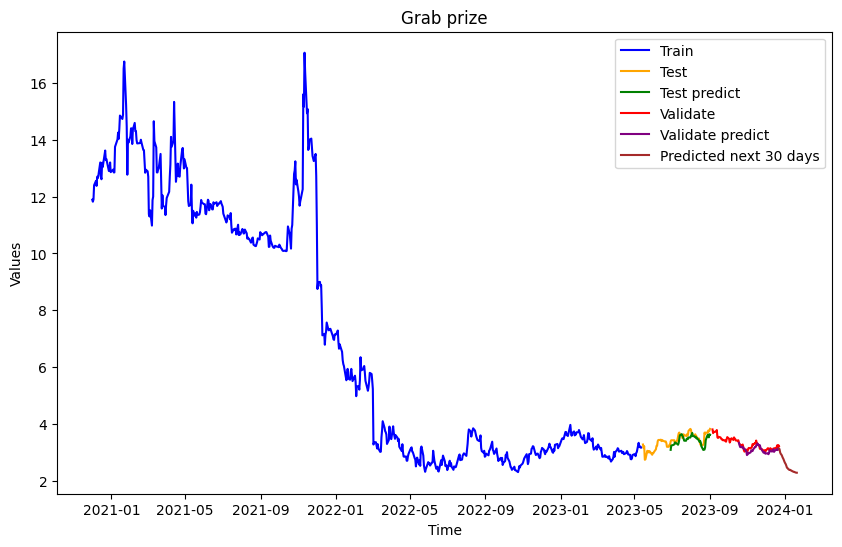

In [66]:
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

date = yf.download(tickers = "GRAB", start="2020-12-01", end="2023-12-26", interval='1d')
date = date.reset_index()

plt.figure(figsize=(10, 6)) 

train_plot = scaler.inverse_transform(train_data)
test_plot = scaler.inverse_transform(test_data)
test_pred_plot = y_pred
val_plot = scaler.inverse_transform(val_data)
val_pred_plot = y_pred_val
predicted_data = np.array(scaler.inverse_transform(lst_output).flatten())
# Plot real data
plt.plot(date['Date'][:len(train_plot)],train_plot, label='Train', color='blue')

# Plot predicted data starting from the end of real data
start_index = len(train_data)
end_index = start_index + len(test_data)
plt.plot(date['Date'][start_index:end_index], test_plot, label='Test', color='orange')
plt.plot(date['Date'][end_index-len(y_pred):end_index], test_pred_plot, label='Test predict', color='green')
# Plot predicted data starting from the end of real data
start_index = end_index
end_index = start_index + len(val_data)
plt.plot(date['Date'][start_index:end_index], val_plot, label='Validate', color='red')
plt.plot(date['Date'][end_index-len(y_pred_val):end_index], y_pred_val, label='Validate predict', color='purple')
# Plot predicted data starting from the end of real data
start_index = end_index
end_index = start_index + len(predicted_data)
plt.plot(pd.date_range(start=date['Date'].iloc[-1], end="2024-01-20", freq='D'), predicted_data, label='Predicted next 30 days', color='brown')


# Set labels and title
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Grab prize')
plt.legend()

plt.show()